In [40]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
import matplotlib.image as mpimg
from utils.ising import metropolis_ising

from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)

    return Y


def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    X = X - np.mean(X, 0)
    cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
    return cov_matrix


def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]

    return evals, evectors


def pca_func(X):
    """
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

    Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

    Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

    """

    X = X - np.mean(X, 0)
    cov_matrix = get_sample_cov_matrix(X)
    evals, evectors = np.linalg.eigh(cov_matrix)
    evals, evectors = sort_evals_descending(evals, evectors)
    score = change_of_basis(X, evectors)

    return score, evectors, evals

def reconstruct_data(score, evectors, X_mean, K):
    """
    Reconstruct the data based on the top K components.

    Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

    Returns:
    (numpy array of floats)          : Matrix of reconstructed data
    """

    X_reconstructed =  score[:, :K]@evectors[:, :K].T + X_mean 

    return X_reconstructed

def plot_pca_weights(weights, shape = (28,28)):
    """
    Visualize PCA basis vector weights. Red = positive weights,
    blue = negative weights, white = zero weight.

    Args:
     weights (numpy array of floats) : PCA basis vector
    """

    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('seismic')
    plt.imshow(np.real(np.reshape(weights, shape)), cmap=cmap)
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
#     plt.clim(-.15, .15)
#     plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [6]:
mnist = fetch_openml(name='mnist_784', as_frame = False)
X = mnist.data
score, evectors, evals = pca(X)

In [9]:
K = 784

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

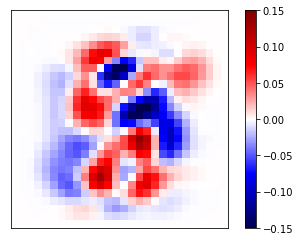

In [17]:
plot_pca_weights(evectors[:, 15])

In [28]:
def load_alphabet_imgs(dir_='/Users/brianbarry/Desktop/AppsComputing/ALPHA_IMAGES'):
    imgs = []
    for im in os.listdir(dir_):
        x = mpimg.imread(dir_+'/'+im)
        x = x[:510,30:540,0] # crop and grayscale 
        imgs.append(x.flatten())
    return np.array(imgs)
          
alph = load_alphabet_imgs()      
pca = PCA(n_components = 26)
pca.fit(alph)
# alph_score, alph_evectors, alph_evals = pca(alph)

PCA(n_components=26)

([], <a list of 0 Text yticklabel objects>)

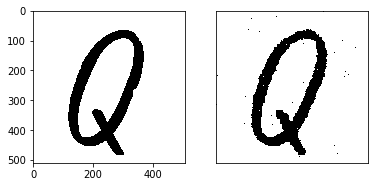

In [52]:
a= alph[0]
a[a<=.1] = -1
a[a>.1]=1
plt.imshow(a.reshape(510,510))
noised = metropolis_ising(1.2,runtime=500,N=a.shape[0],grid=a.reshape(510,510))
plt.subplot(1,2,1)
plt.imshow(a.reshape(510,510), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(noised, cmap='gray')
plt.xticks([]); plt.yticks([])

In [19]:
pca.components_.shape

(26, 260100)

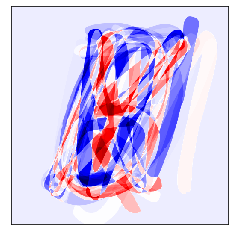

In [38]:
plot_pca_weights(pca.components_[12, :], (510,510))